# Hyperparameters

Consider the Booth test function (below). This function varies differently in different directions, and these directions are somewhat skewed with respect to the inputs. Our agent will automatically fit the right hyperparameters to account for this.

/home/jmoylan1/miniconda3/envs/test_tiled_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, 'x2')

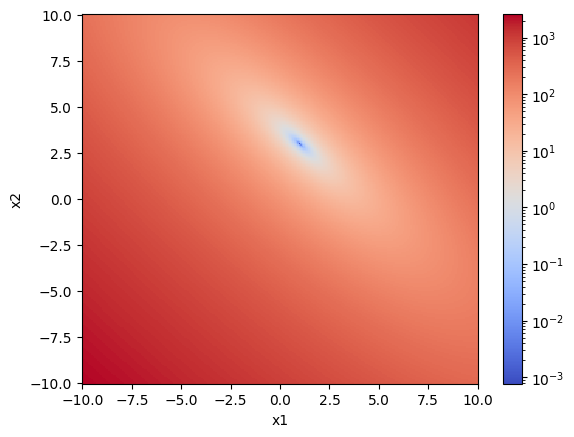

In [1]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from blop.utils import functions

x1 = x2 = np.linspace(-10, 10, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.booth(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

The optimization goes faster if our model understands how the function changes as we change the inputs in different ways. The way it picks up on this is by starting from a general model that could describe a lot of functions, and making it specific to this one by choosing the right hyperparameters. Our Bayesian agent is very good at this, and only needs a few samples to figure out what the function looks like:

In [2]:
def digestion(df):
    for index, entry in df.iterrows():
        df.loc[index, "booth"] = functions.booth(entry.x1, entry.x2)

    return df

In [ ]:
import datetime
from bluesky.run_engine import RunEngine
from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from tiled.client import from_uri
from ophyd.utils import make_dir_tree# Constants
from tiled.server import SimpleTiledServer
from tiled.client import from_uri


SERVER_HOST_LOCATION = "http://localhost:8000"
DEFAULT_DB_TYPE = "local"
DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"# Initialize Tiled client

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)# Function to set up Bluesky environment

def setup_re_env(tiled_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return dict(RE=RE, tiled=tiled_client, bec=bec)# Initialize the environment
env = setup_re_env(tiled_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

2025-05-09 13:56:15.715 INFO: Subprocess stdout: 
2025-05-09 13:56:15.716 INFO: Subprocess stderr: Database sqlite+aiosqlite:////tmp/tmpdcrwdq3z/catalog.db is new. Creating tables.
Database initialized.

Tiled version 0.1.0b21
2025-05-09 13:56:15.986 INFO: Tiled version 0.1.0b21
2025-05-09 13:56:15.988 INFO: Context impl SQLiteImpl.
2025-05-09 13:56:15.988 INFO: Will assume non-transactional DDL.
2025-05-09 13:56:16.093 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1?api_key=b031a444307c273e "HTTP/1.1 307 Temporary Redirect"
2025-05-09 13:56:16.099 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/ "HTTP/1.1 200 OK"
2025-05-09 13:56:16.120 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"


2025-05-09 13:56:16.845 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/table/partition/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:18.510 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/table/partition/42879408-a6ee-46ea-8a81-08ed98954962/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:20.700 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/table/partition/c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:21.696 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/table/partition/e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:22.530 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/table/partition/75011092-23da-481a-a481-ca9efa4974aa/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


In [4]:
import datetime

from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from bluesky.run_engine import RunEngine
from ophyd.utils import make_dir_tree  # Constants
from tiled.client import from_uri
from tiled.server import SimpleTiledServer

SERVER_HOST_LOCATION = "http://localhost:8000"
DEFAULT_DB_TYPE = "local"
DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"  # Initialize Tiled client

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)  # Function to set up Bluesky environment


def setup_re_env(tiled_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return {"RE": RE, "tiled": tiled_client, "bec": bec}  # Initialize the environment


env = setup_re_env(tiled_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

2025-05-09 13:56:16.128 INFO: Executing plan <generator object Agent.learn at 0x7fca30492d90>
2025-05-09 13:56:16.128 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7fca30a65010> from 'idle' -> 'running'
2025-05-09 13:56:16.150 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-05-09 13:56:16.160 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search//0311aebf-cf83-47c2-b911-f76d70e53d5d?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:16.168 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d "HTTP/1.1 200 OK"
2025-05-09 13:56:16.175 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:16.184 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:16.191 INFO: HTTP Request: POST h



Transient Scan ID: 1     Time: 2025-05-09 13:56:16
Persistent Unique Scan ID: '0311aebf-cf83-47c2-b911-f76d70e53d5d'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 13:56:16.2 |      0.160 |     -0.189 |
|         2 | 13:56:16.3 |     -0.721 |      0.276 |


2025-05-09 13:56:16.344 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:16.351 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:16.357 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:16.363 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:16.370 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:16.376 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b91

|         3 | 13:56:16.3 |     -3.240 |      1.707 |
|         4 | 13:56:16.3 |     -5.590 |     -0.980 |
|         5 | 13:56:16.3 |     -4.158 |     -3.322 |
|         6 | 13:56:16.4 |     -2.872 |     -2.503 |
|         7 | 13:56:16.4 |     -0.881 |     -4.848 |
|         8 | 13:56:16.4 |      2.104 |     -4.032 |
|         9 | 13:56:16.5 |      4.810 |     -5.604 |
|        10 | 13:56:16.5 |      3.425 |     -1.759 |


2025-05-09 13:56:16.551 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:16.558 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:16.564 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:16.571 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:16.578 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:16.585 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b91

|        11 | 13:56:16.5 |      5.775 |      0.986 |
|        12 | 13:56:16.5 |      3.972 |      3.331 |
|        13 | 13:56:16.6 |      2.311 |      2.462 |
|        14 | 13:56:16.6 |      1.442 |      4.805 |
|        15 | 13:56:16.6 |     -1.543 |      4.121 |
|        16 | 13:56:16.6 |     -4.995 |      5.549 |


2025-05-09 13:56:16.819 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/metadata//0311aebf-cf83-47c2-b911-f76d70e53d5d "HTTP/1.1 200 OK"
2025-05-09 13:56:16.825 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/0311aebf-cf83-47c2-b911-f76d70e53d5d "HTTP/1.1 200 OK"
2025-05-09 13:56:16.832 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/0311aebf-cf83-47c2-b911-f76d70e53d5d/primary/internal/events "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['0311aebf'] (scan num: 1)





2025-05-09 13:56:17.021 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7fca30a65010> from 'running' -> 'idle'
2025-05-09 13:56:17.022 INFO: Cleaned up from plan <generator object Agent.learn at 0x7fca30492d90>


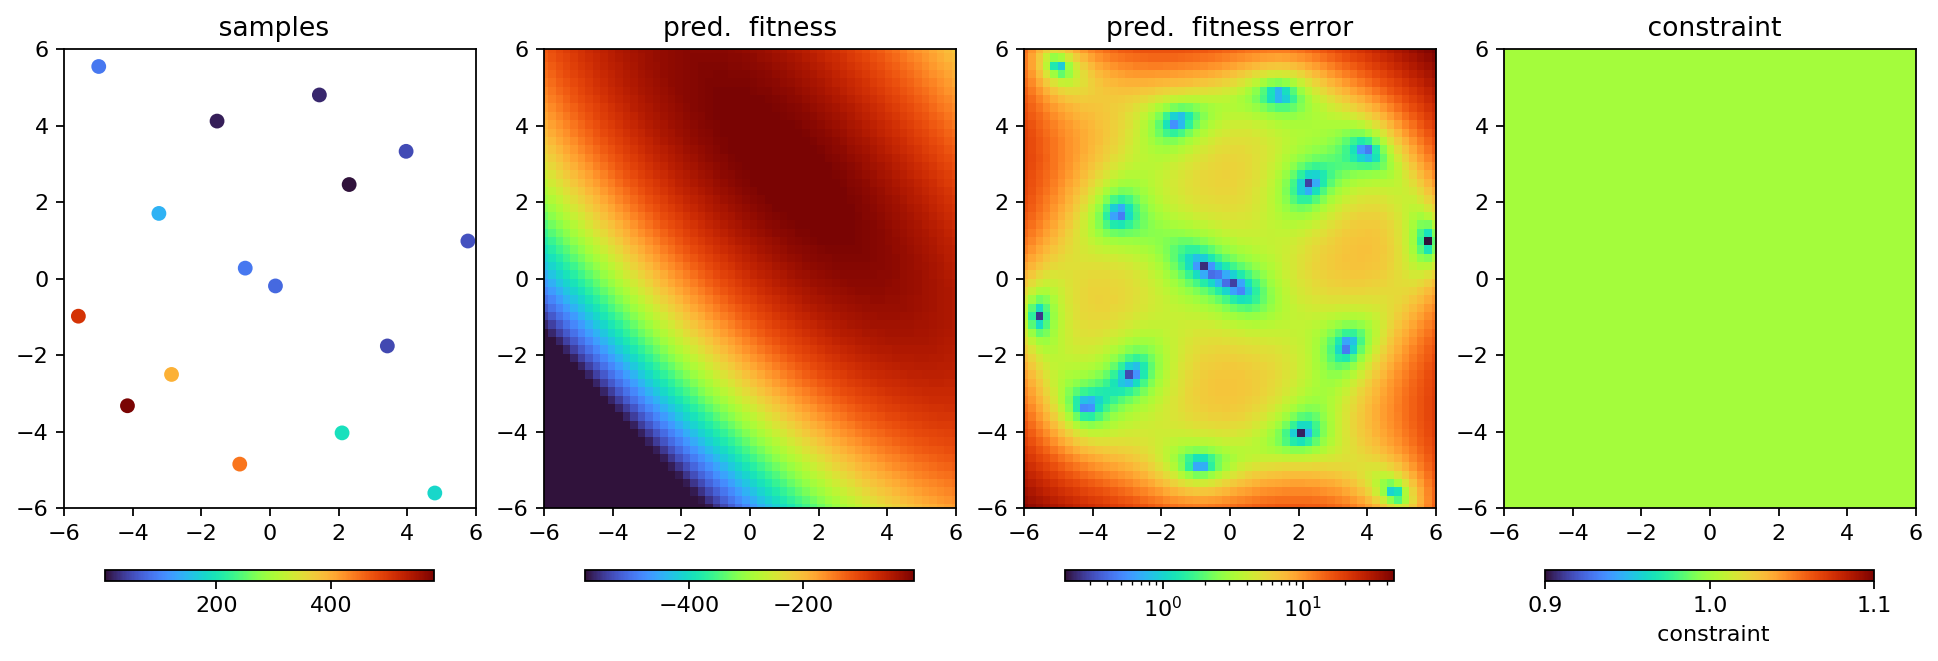

In [ ]:
from blop import DOF, Agent, Objective

dofs = [
    DOF(name="x1", search_domain=(-6, 6)),
    DOF(name="x2", search_domain=(-6, 6)),
]

objectives = [
    Objective(name="booth", target="min"),
]


agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    tiled=tiled,
)

RE(agent.learn(acqf="qr", n=16))

agent.plot_objectives()

In addition to modeling the fitness of the task, the agent models the probability that an input will be feasible:

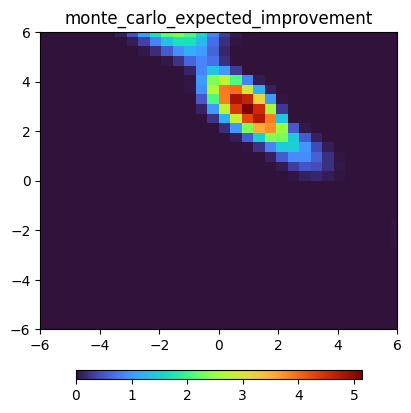

In [ ]:
agent.plot_acquisition(acqf="qei")

2025-05-09 13:56:17.447 INFO: Executing plan <generator object Agent.learn at 0x7fca12168040>
2025-05-09 13:56:17.447 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7fca30a65010> from 'idle' -> 'running'
2025-05-09 13:56:18.141 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-05-09 13:56:18.150 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search//42879408-a6ee-46ea-8a81-08ed98954962?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:18.158 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//42879408-a6ee-46ea-8a81-08ed98954962 "HTTP/1.1 200 OK"
2025-05-09 13:56:18.166 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//42879408-a6ee-46ea-8a81-08ed98954962/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:18.174 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//42879408-a6ee-46ea-8a81-08ed98954962/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:18.181 INFO: HTTP Request: POST h



Transient Scan ID: 2     Time: 2025-05-09 13:56:18
Persistent Unique Scan ID: '42879408-a6ee-46ea-8a81-08ed98954962'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 13:56:18.2 |     -1.417 |      6.000 |
|         2 | 13:56:18.2 |      0.964 |      2.952 |
|         3 | 13:56:18.3 |      1.498 |      2.380 |


2025-05-09 13:56:18.335 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/42879408-a6ee-46ea-8a81-08ed98954962/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:18.341 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/42879408-a6ee-46ea-8a81-08ed98954962/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:18.348 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/42879408-a6ee-46ea-8a81-08ed98954962/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:18.355 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//42879408-a6ee-46ea-8a81-08ed98954962/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:18.360 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/42879408-a6ee-46ea-8a81-08ed98954962/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:18.366 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/42879408-a6ee-46ea-8

|         4 | 13:56:18.3 |      2.135 |      1.746 |
+-----------+------------+------------+------------+
generator list_scan ['42879408'] (scan num: 2)





2025-05-09 13:56:20.337 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-05-09 13:56:20.345 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:20.353 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370 "HTTP/1.1 200 OK"
2025-05-09 13:56:20.361 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:20.368 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:20.375 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:20.383 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed



Transient Scan ID: 3     Time: 2025-05-09 13:56:20
Persistent Unique Scan ID: 'c1cc47d6-7fb7-4781-9b08-7b5ed11e7370'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 13:56:20.4 |      1.123 |      2.938 |
|         2 | 13:56:20.4 |      0.763 |      3.168 |
|         3 | 13:56:20.5 |      0.507 |      3.482 |


2025-05-09 13:56:20.531 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:20.538 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:20.544 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:20.550 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:20.556 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/c1cc47d6-7fb7-4781-9b08-7b5ed11e7370/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:20.563 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/c1cc47d6-7fb7-4781-9b08-7b5ed11e737

|         4 | 13:56:20.5 |      0.187 |      3.838 |
+-----------+------------+------------+------------+
generator list_scan ['c1cc47d6'] (scan num: 3)





/home/jmoylan1/miniconda3/envs/test_tiled_new/lib/python3.11/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  warn(
2025-05-09 13:56:21.328 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-05-09 13:56:21.336 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search//e624c95d-f4e3-4b4d-a703-b514463e48c9?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:21.344 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//e624c95d-f4e3-4b4d-a703-b514463e48c9 "HTTP/1.1 200 OK"
2025-05-09 13:56:21.351 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//e624c95d-f4e3-4b4d-a703-b514463e48c9/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:21.359 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//e624c95d-f4e3-4b4d-a703-b514463e48c9/primary "HTTP/1.1 200 OK"
20



Transient Scan ID: 4     Time: 2025-05-09 13:56:21
Persistent Unique Scan ID: 'e624c95d-f4e3-4b4d-a703-b514463e48c9'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 13:56:21.4 |      0.838 |      3.109 |
|         2 | 13:56:21.4 |      0.983 |      3.132 |
|         3 | 13:56:21.5 |      1.021 |      3.000 |


2025-05-09 13:56:21.524 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:21.531 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:21.538 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:21.544 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:21.550 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/e624c95d-f4e3-4b4d-a703-b514463e48c9/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:21.557 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/e624c95d-f4e3-4b4d-a703-b514463e48c

|         4 | 13:56:21.5 |      0.932 |      2.953 |
+-----------+------------+------------+------------+
generator list_scan ['e624c95d'] (scan num: 4)





2025-05-09 13:56:22.160 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-05-09 13:56:22.168 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search//75011092-23da-481a-a481-ca9efa4974aa?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:22.176 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9efa4974aa "HTTP/1.1 200 OK"
2025-05-09 13:56:22.183 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9efa4974aa/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:22.190 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9efa4974aa/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:22.198 INFO: HTTP Request: POST http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9efa4974aa/primary "HTTP/1.1 200 OK"
2025-05-09 13:56:22.206 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9ef



Transient Scan ID: 5     Time: 2025-05-09 13:56:22
Persistent Unique Scan ID: '75011092-23da-481a-a481-ca9efa4974aa'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 13:56:22.2 |      0.938 |      2.971 |
|         2 | 13:56:22.3 |      0.930 |      3.121 |
|         3 | 13:56:22.3 |      1.043 |      2.971 |


2025-05-09 13:56:22.353 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/75011092-23da-481a-a481-ca9efa4974aa/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:22.359 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/75011092-23da-481a-a481-ca9efa4974aa/primary/internal/events "HTTP/1.1 200 OK"
2025-05-09 13:56:22.367 INFO: HTTP Request: PATCH http://127.0.0.1:33983/api/v1/table/partition/75011092-23da-481a-a481-ca9efa4974aa/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-09 13:56:22.373 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata//75011092-23da-481a-a481-ca9efa4974aa/primary/internal "HTTP/1.1 200 OK"
2025-05-09 13:56:22.379 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/search/75011092-23da-481a-a481-ca9efa4974aa/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-09 13:56:22.386 INFO: HTTP Request: GET http://127.0.0.1:33983/api/v1/metadata/75011092-23da-481a-a

|         4 | 13:56:22.3 |      1.159 |      2.854 |
+-----------+------------+------------+------------+
generator list_scan ['75011092'] (scan num: 5)





2025-05-09 13:56:22.590 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7fca30a65010> from 'running' -> 'idle'
2025-05-09 13:56:22.590 INFO: Cleaned up from plan <generator object Agent.learn at 0x7fca12168040>


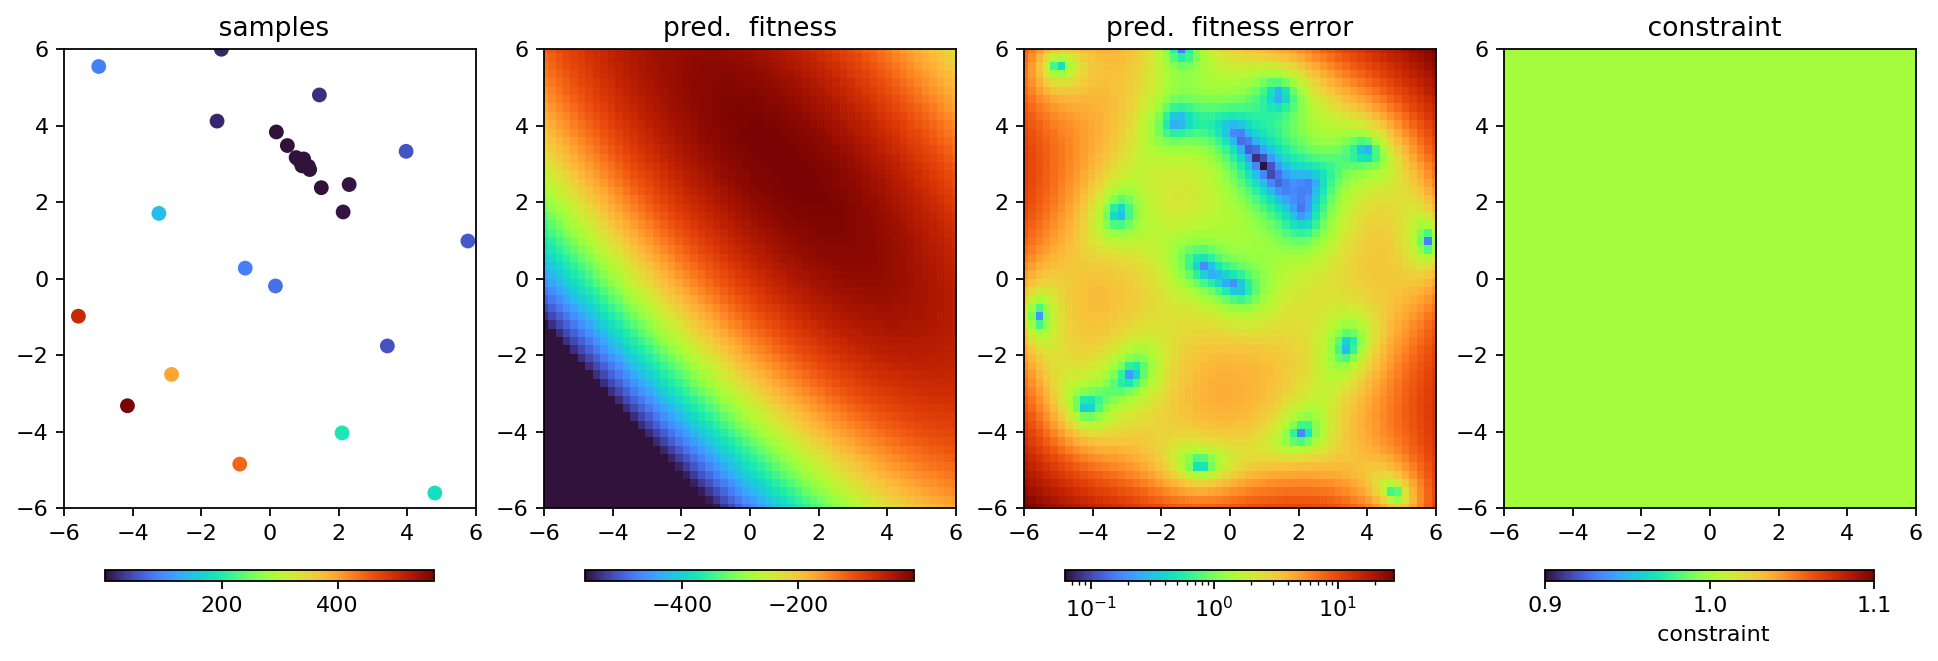

In [ ]:
RE(agent.learn("qei", n=4, iterations=4))
agent.plot_objectives()

In [7]:
agent.best

x1                                 1.020914
x2                                 2.999606
booth                              0.002122
seq_num                                   3
ts_x1                     1746813381.505637
ts_x2                     1746813381.505804
acqf       monte_carlo_expected_improvement
Name: 26, dtype: object

In [8]:
tiled_server.close()

In [ ]:
tiled_server.close()